In [74]:
# source of reference code  https://www.tensorflow.org/tutorials/text/classify_text_with_bert

import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split

df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

# take samples from the population 
sample_fake = df_fake.sample(frac = 0.1,random_state=42)
sample_true = df_true.sample(frac = 0.1,random_state = 42)

# concate title , text , and type of news together , as in addition to text, title and types of news may be indicative. 
sample_fake = sample_fake.dropna(subset= ['title','text'])
sample_ture = sample_true.dropna(subset= ['title','text'])
sample_fake['text'] = sample_fake['title']+' '+sample_fake['text']+' '+ sample_fake['subject']
sample_true['text'] = sample_true['title']+' '+sample_true['text']+' '+ sample_true['subject']
sample_fake = sample_fake['text']
sample_true = sample_true['text']


# split text data into train and test datasets
train_fake,test_fake = train_test_split(sample_fake,test_size = 0.2,random_state = 42)
train_true,test_true = train_test_split(sample_true,test_size = 0.2,random_state = 42)

# write into the txt format required by the next process 

def write_file(df,name1,name2):
    n = len(df)
    for i in range(n):
        with open('{}/{}/{}.txt'.format(name1,name2,i),'w') as text_file:
            text_file.write(df.iloc[i])

write_file(train_fake,'train','1_fake')
write_file(train_true,'train','0_true')
write_file(test_true,'test','0_true')
write_file(test_fake,'test','1_fake')

In [77]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

# prepare train dataset
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    label_mode='binary',
    seed = seed)

# fake news will be labeled as 1, and true 0.
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# validation dateset
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    label_mode = 'binary',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_dataset
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test',
    batch_size=batch_size,
    label_mode = 'binary'
   )

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 3591 files belonging to 2 classes.
Using 2873 files for training.
Found 3591 files belonging to 2 classes.
Using 718 files for validation.
Found 899 files belonging to 2 classes.


In [98]:

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# use small_bert model and bert_en_uncased_preprocess layer.
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)


In [38]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [108]:

classifier_model = build_classifier_model()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics = tf.metrics.BinaryAccuracy()


epochs = 3

optimizer =tf.keras.optimizers.Adam(
    learning_rate=0.001, 
    name='Adam'
)


classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [105]:
print(classifier_model.summary())

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  22458881    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
___________________________________________________________________________________________

In [109]:

history = classifier_model.fit(x=train_ds, validation_data=val_ds,epochs=epochs)



Epoch 1/3
90/90 [==============================] - 451s 5s/step - loss: 0.4689 - binary_accuracy: 0.8513 - val_loss: 0.0274 - val_binary_accuracy: 0.9972
Epoch 2/3
90/90 [==============================] - 408s 5s/step - loss: 0.1095 - binary_accuracy: 0.9706 - val_loss: 0.0187 - val_binary_accuracy: 0.9972
Epoch 3/3
90/90 [==============================] - 260s 3s/step - loss: 0.0341 - binary_accuracy: 0.9945 - val_loss: 0.0187 - val_binary_accuracy: 0.9972


In [110]:
# code reference https://stackoverflow.com/questions/64687375/
#get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory/64689000
# make predictions and use label to calculate f1 score
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, classifier_model.predict(x)[0]])
    labels = np.concatenate([labels, y[0]])
predictions=predictions>0.5
f1 = f1_score(labels,predictions)
print('f1 score is {}'.format(f1))

f1 score is 1.0


29/29 [==============================] - 25s 851ms/step - loss: 0.0229 - binary_accuracy: 0.9967
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


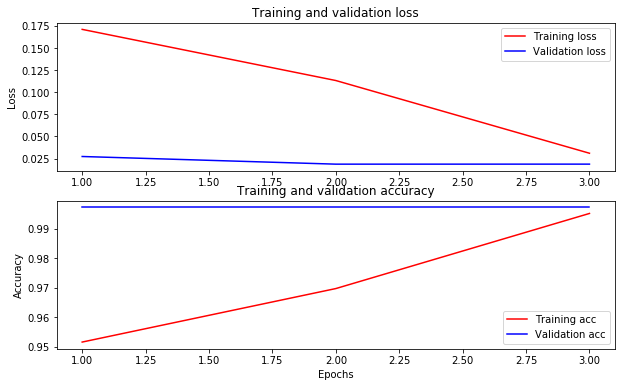

In [113]:
# evaluate the model
import matplotlib.pyplot as plt 
loss, accuracy = classifier_model.evaluate(test_ds)
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
